## Imports and data ingestion

`linear_model` for Logistic Regression,

`model_selection` for train-test split and cross-validation,

`metrics` for ROC and AIC

In [209]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met

In [210]:
rawData = pd.read_csv('train.csv')

## Get Dummies

`Lead` is `0` if the lead is `female`.

In [211]:
data = rawData.copy()
data['Lead'] = pd.get_dummies(data['Lead'])

## Feature Engineering

We first extract the number of words spoken by the co-lead.

In [212]:
data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']

It is probably more important to know proportion of words spoken by lead than the absolute number of words.

In [213]:
data['Proportion of words lead'] = data['Number of words lead']/data['Total words']

We look at the proportion of dialogue from co-lead as well as the ratio of dialogue between co-lead and lead.

In [214]:
data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']

Similarly for number of words spoken by male or female actors. However, here we normalize by `Total words - Number of words lead` since this only measures non-lead dialogue. We only need `Proportion of words female` since a hypothetical `Proportion of words male` is just `1 - Proportion of words female`.

In [215]:
data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])

It might be important to look at the ratio of female actors.

In [216]:
data['Proportion of female actors'] = data['Number of female actors']/(data['Number of male actors'] + data['Number of female actors'])

Perhaps it is important if the lead or co-lead is oldest.

In [217]:
data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
data['Older lead'] = pd.get_dummies(data['Older lead'])

In [218]:
data.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'Lead',
       'Number of words co-lead', 'Proportion of words lead',
       'Proportion of words co-lead', 'Ratio words co-lead lead',
       'Proportion of words female', 'Proportion of female actors',
       'Older lead'],
      dtype='object')

# Logistic Regression

In [219]:
config = pd.read_csv('config.csv')
trainRatio = config['Train Ratio'][0]
seed = config['Random Seed'][0]
train, test = skl_ms.train_test_split(data, train_size=trainRatio, random_state=seed)

In [220]:
rawFeatures = [
    'Number words female',
    'Total words',
    'Number of words lead',
    'Difference in words lead and co-lead',
    'Number of male actors',
    'Year',
    'Number of female actors',
    'Number words male',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead'
]

featureSet1 = [
    'Year',
    'Gross',
    'Number of female actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead'
]

In [221]:
features = featureSet1.copy()
#features.remove('Proportion of words female')
target = 'Lead'

## Lasso

Lasso is L1 regularization

We do 10 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 100 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [222]:
logRegLasso = skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l1', solver='liblinear', n_jobs=10)

In [223]:
logRegLasso.fit(train[features], train[target])

LogisticRegressionCV(cv=10, n_jobs=10, penalty='l1', solver='liblinear')

In [224]:
logRegLasso.score(test[features], test[target])

0.9230769230769231

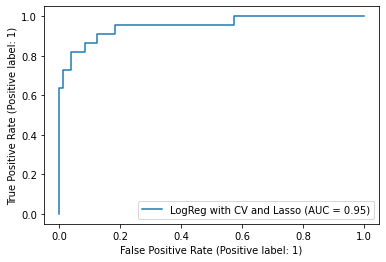

In [225]:
skl_met.plot_roc_curve(logRegLasso, test[features], test[target], name='LogReg with CV and Lasso')

In [226]:
skl_met.roc_auc_score(test[target], logRegLasso.predict_proba(test[features])[:,1])

0.9517738359201774

In [227]:
print(skl_met.classification_report(test[target], logRegLasso.predict(test[features])))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        82
           1       0.85      0.77      0.81        22

    accuracy                           0.92       104
   macro avg       0.90      0.87      0.88       104
weighted avg       0.92      0.92      0.92       104



## Ridge

Ridge is L2-regularization

We do 10 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 100 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [228]:
logRegRidge = skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear', n_jobs=10)
logRegRidge.fit(train[features], train[target])

LogisticRegressionCV(cv=10, n_jobs=10, solver='liblinear')

In [229]:
logRegRidge.score(test[features], test[target])

0.8942307692307693

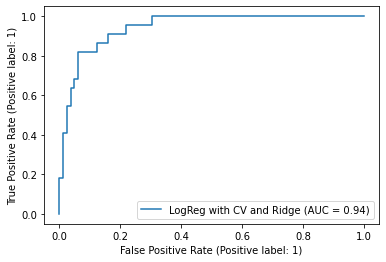

In [230]:
skl_met.plot_roc_curve(logRegRidge, test[features], test[target], name='LogReg with CV and Ridge')

In [231]:
skl_met.roc_auc_score(test[target], logRegRidge.predict_proba(test[features])[:,1])

0.9434589800443458

In [232]:
print(skl_met.classification_report(test[target], logRegRidge.predict(test[features])))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        82
           1       0.82      0.64      0.72        22

    accuracy                           0.89       104
   macro avg       0.87      0.80      0.83       104
weighted avg       0.89      0.89      0.89       104



## Comparison

In [233]:
logRegLasso.C_

array([21.5443469])

In [234]:
logRegRidge.C_

array([21.5443469])

In [235]:
predLasso = logRegLasso.predict(test[features])
predRidge = logRegRidge.predict(test[features])

In [236]:
logRegLassoCoefs = dict(zip(features, logRegLasso.coef_[0]))

In [237]:
for var, coef in logRegLassoCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.00178
Gross                                    -0.00051
Number of female actors                  0.25071
Proportion of female actors              15.97350
Mean Age Male                            0.02754
Mean Age Female                          0.00459
Age Lead                                 -0.03613
Age Co-Lead                              0.02511
Total words                              -0.00007
Proportion of words lead                 2.35565
Proportion of words co-lead              5.17208
Ratio words co-lead lead                 2.73479
Proportion of words female               -11.70041
Older lead                               -1.05580


In [238]:
logRegRidgeCoefs = dict(zip(features, logRegRidge.coef_[0]))

In [239]:
for var, coef in logRegRidgeCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.00125
Gross                                    -0.00037
Number of female actors                  0.45691
Proportion of female actors              1.64488
Mean Age Male                            0.01468
Mean Age Female                          -0.00076
Age Lead                                 -0.02418
Age Co-Lead                              0.01799
Total words                              -0.00010
Proportion of words lead                 0.59328
Proportion of words co-lead              0.91914
Ratio words co-lead lead                 2.02023
Proportion of words female               -2.26946
Older lead                               -1.27401


In [240]:
sum(predLasso == predRidge)/len(test)

0.9134615384615384

In [241]:
pd.crosstab(test[target], predLasso)

col_0,0,1
Lead,,
0,79,3
1,5,17


In [242]:
pd.crosstab(test[target], predRidge)

col_0,0,1
Lead,,
0,79,3
1,8,14
